In [171]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import math
from tqdm.notebook import tqdm

class PDMnist(Dataset):
    def __init__(self, data_dir='data', train=True, num_filtrations=4, limit=None):
        self.dataset = torchvision.datasets.MNIST(root=data_dir, train=train, download=True, transform=transforms.ToTensor())
        self.pds = []
        self.dir_img = []
        filter_params = np.arange(num_filtrations) / num_filtrations * 2 * math.pi
        for i, (img, label) in tqdm(enumerate(self.dataset)):
            if limit is not None and i >= limit:
                break
            
            diags, imgs = process_image(img, filter_params)
            self.pds.append(diags)
            self.dir_img.append(imgs)
        
    def __len__(self):
        return len(self.pds)
    
    def __getitem__(self, idx):
        mnist_img, mnist_label = self.dataset[idx]
        pd = self.pds[idx]
        imgs = self.dir_img[idx]
        return mnist_img, pd, mnist_label, imgs

In [170]:
# https://github.com/ChervovNikita/topological_DL_course_work/utils
import gudhi as gd
import numpy as np
import math

def diagram(image, device, sublevel=True):
    # get height and square image
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h,h))

    # create complex
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=(sublevel * image))

    # get pairs of critical simplices
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()
    
    # get essential critical pixel
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # get critical pixels corresponding to critical simplices
    try:
        bpx0 = [critical_pairs[0][0][i][0] for i in range(len(critical_pairs[0][0]))]
        dpx0 = [critical_pairs[0][0][i][1] for i in range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = []
        dpx0 = []
        
    try:
        bpx1 = [critical_pairs[0][1][i][0] for i in range(len(critical_pairs[0][1]))]
        dpx1 = [critical_pairs[0][1][i][1] for i in range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = []
        dpx1 = []
    

    flat_image = image_sq.flatten()
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    if (len(bpx0)!=0):
        pdb0 = flat_image[bpx0][:, None]
        pdd0 = flat_image[dpx0][:, None]
        pd0 = torch.hstack([pdb0, pdd0])
        pd0 = torch.vstack([pd0, pd0_essential.to(device)])
    else:
        pd0 = pd0_essential

    if (len(bpx1)!=0):
        pdb1 = flat_image[bpx1][:, None]
        pdd1 = flat_image[dpx1][:, None]
        pd1 = torch.hstack([pdb1, pdd1])
    else:
        pd1 = torch.zeros((1, 2))
    
    return pd0, pd1


def process_by_direction(img, alpha):
    X = (math.cos(alpha) - (np.arange(0, img.shape[0]) - (img.shape[0] / 2 - 0.5)) / (img.shape[0] * math.sqrt(2))) * math.cos(alpha) / 2
    Y = (math.sin(alpha) - (np.arange(0, img.shape[1]) - (img.shape[1] / 2 - 0.5)) / (img.shape[1] * math.sqrt(2))) * math.sin(alpha) / 2
    direction_filter = X.reshape(-1, 1) + Y.reshape(1, -1)
    return np.maximum(direction_filter, img)


def process_image(img, filter_params):
    w = img.shape[-1]
    imgs = [process_by_direction(img.reshape(w, w), alpha) for alpha in filter_params]
    diagrams = []
    for i, img in enumerate(imgs):
        pd0, pd1 = diagram(img.flatten(), img.device)
        add_features0 = torch.tensor([0., filter_params[i]])
        add_features1 = torch.tensor([1., filter_params[i]])
        pd0 = torch.cat([pd0, add_features0.view(1, -1).repeat(pd0.shape[0], 1)], axis=1)
        pd1 = torch.cat([pd1, add_features1.view(1 ,-1).repeat(pd1.shape[0], 1)], axis=1)
        diagrams.append(torch.cat([pd0, pd1], axis=0))
    diagrams = torch.cat(diagrams)
    return diagrams, imgs

In [172]:
mnist_filt_tr_lim = PDMnist(limit=10)

0it [00:00, ?it/s]

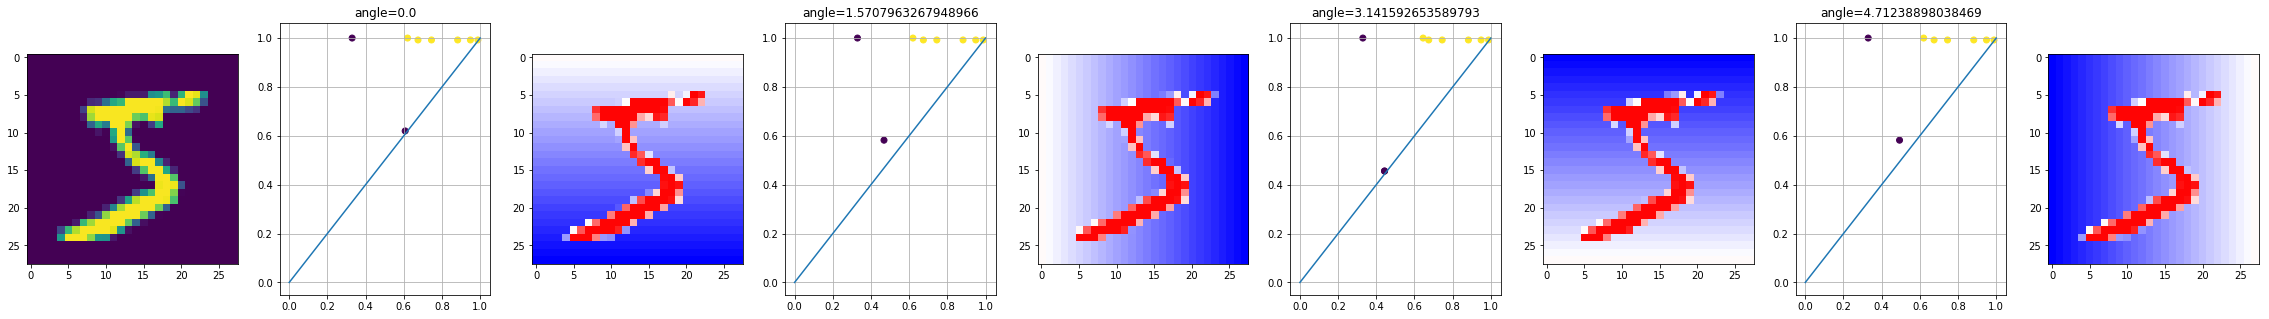

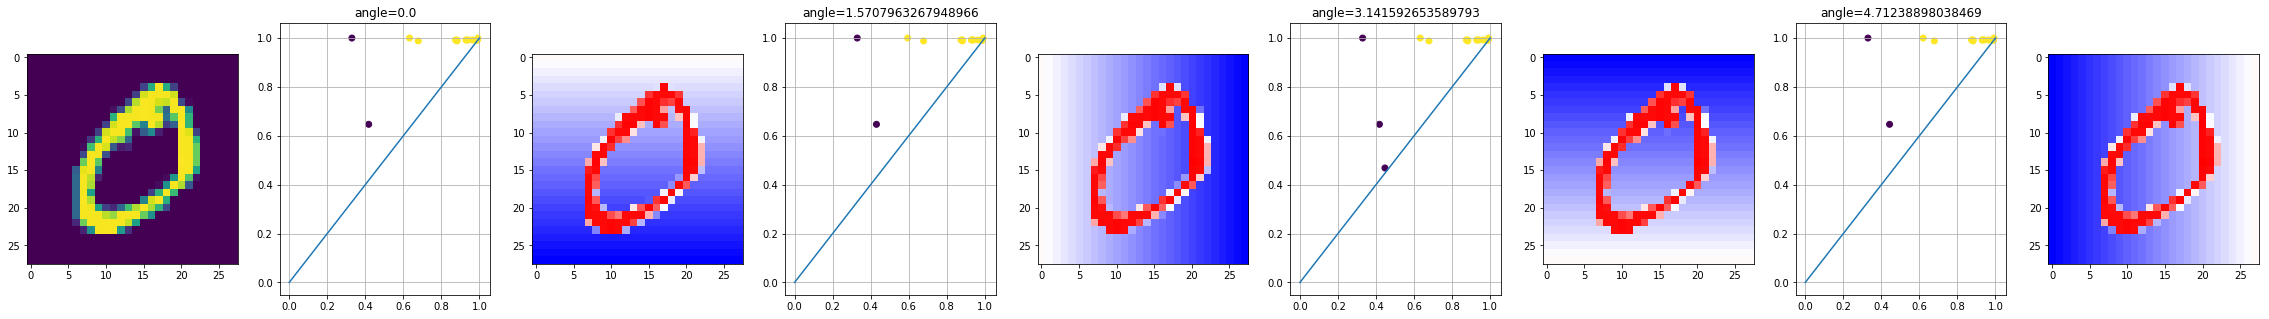

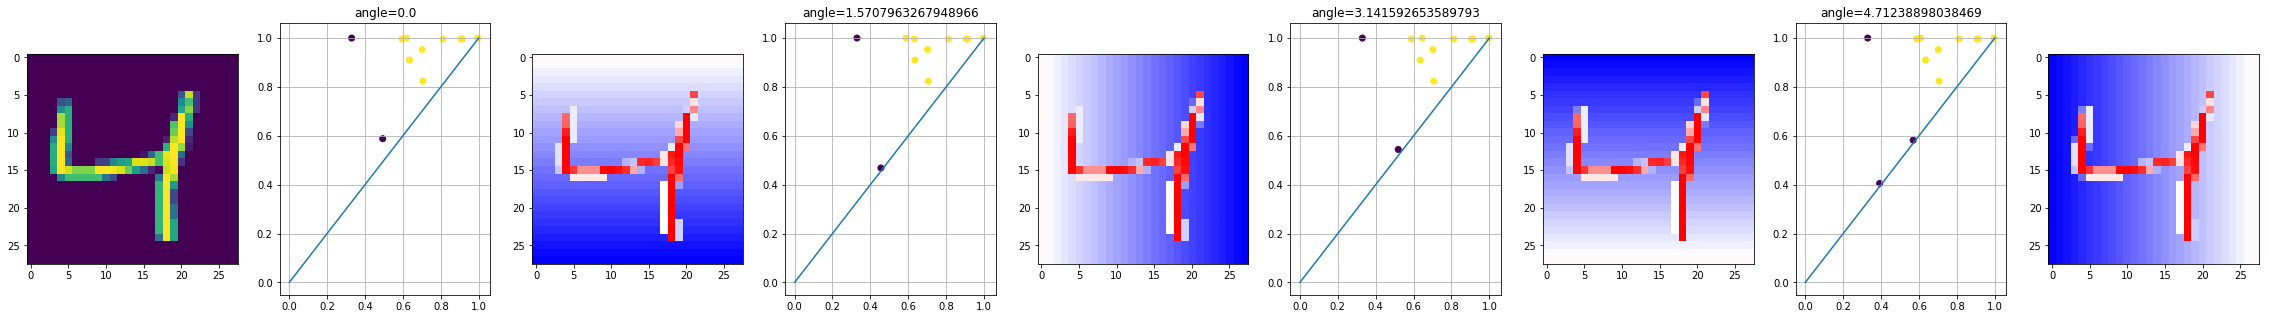

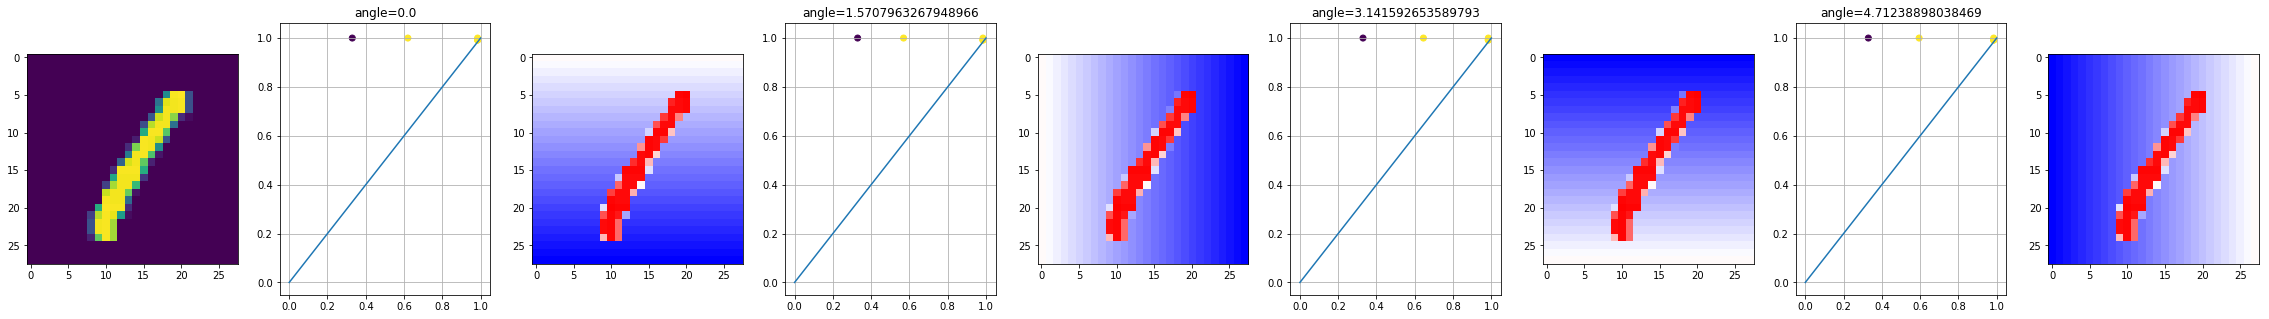

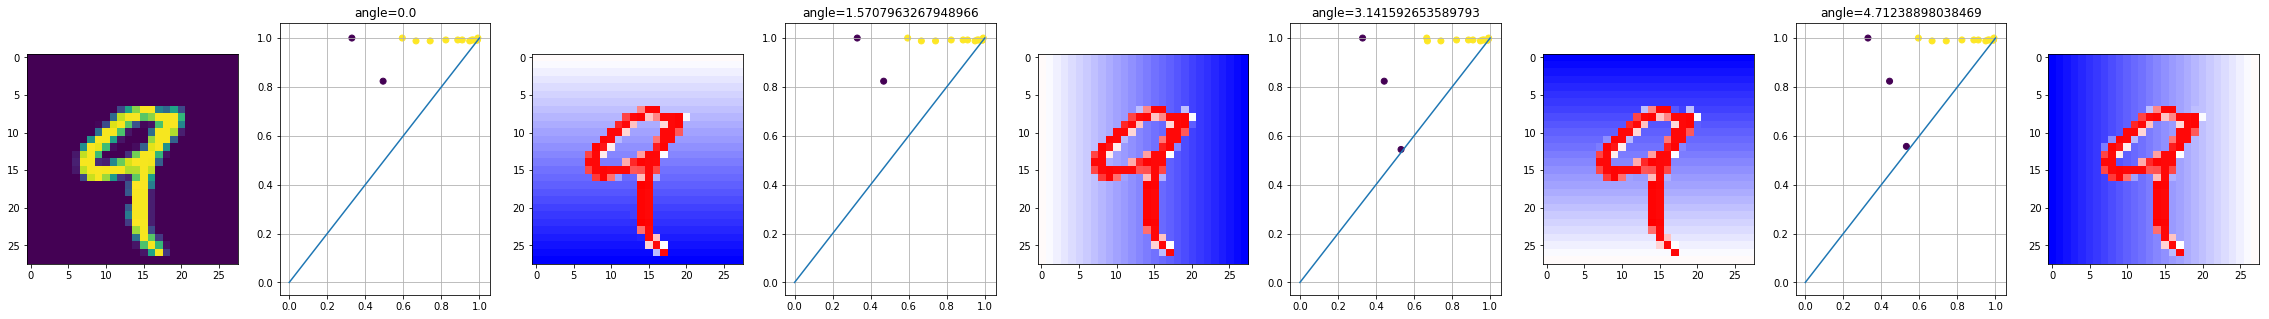

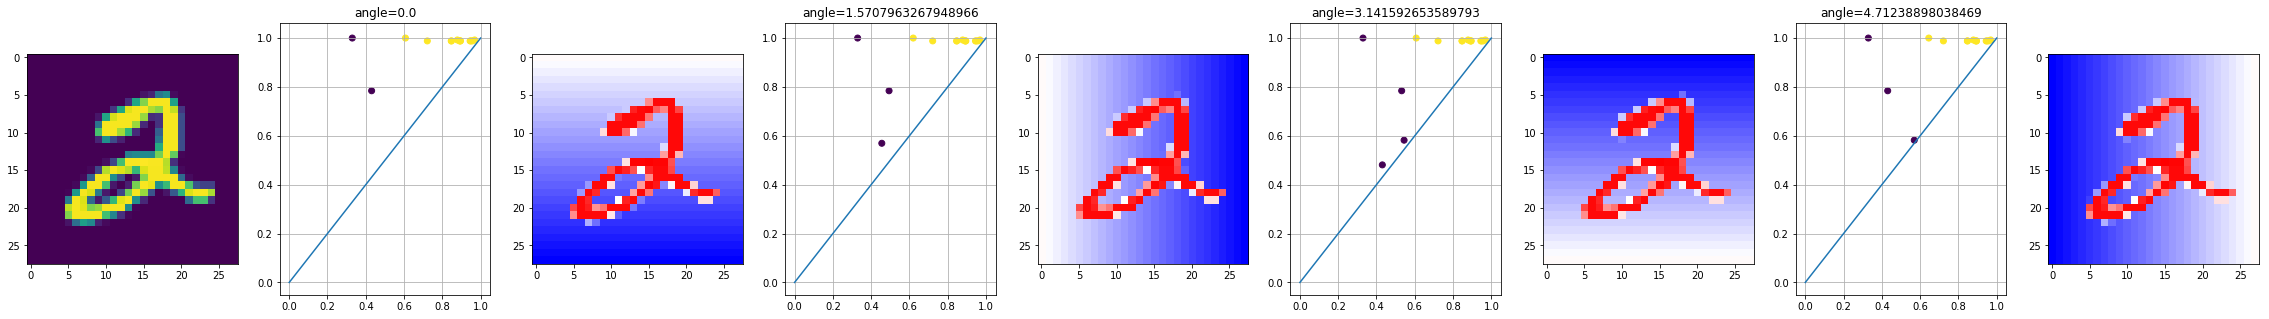

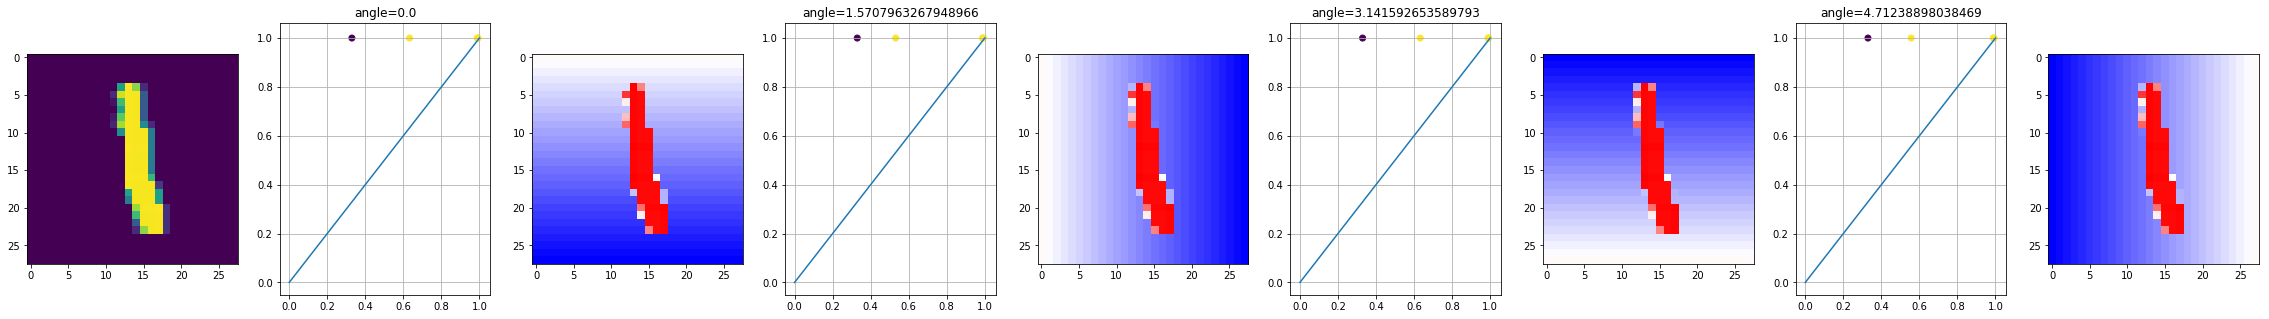

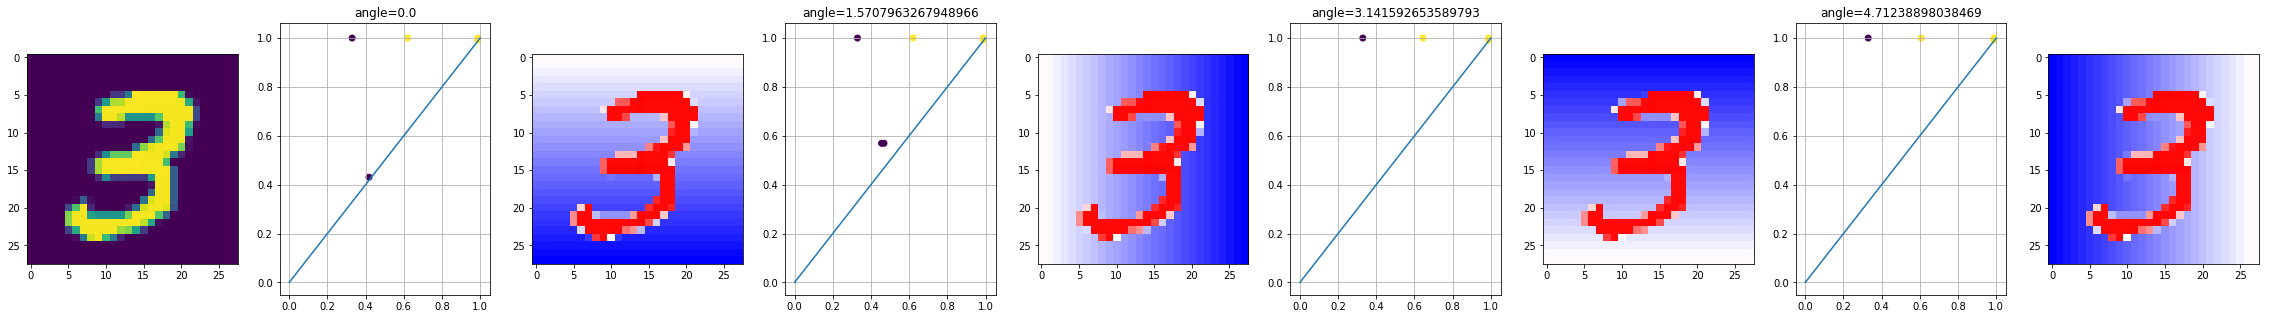

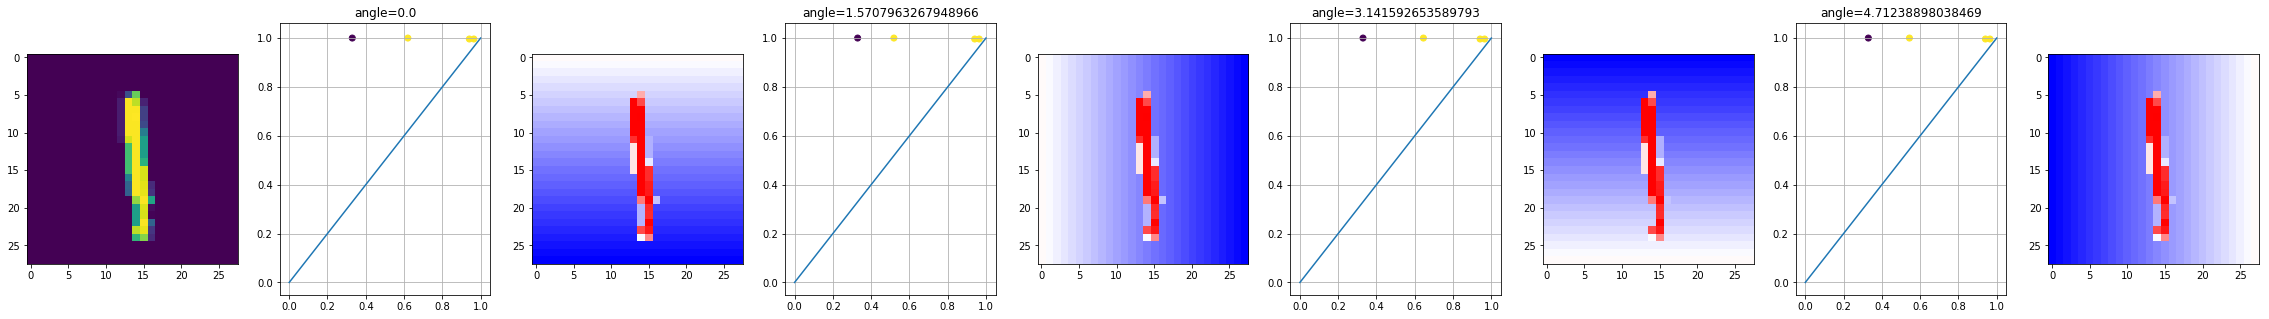

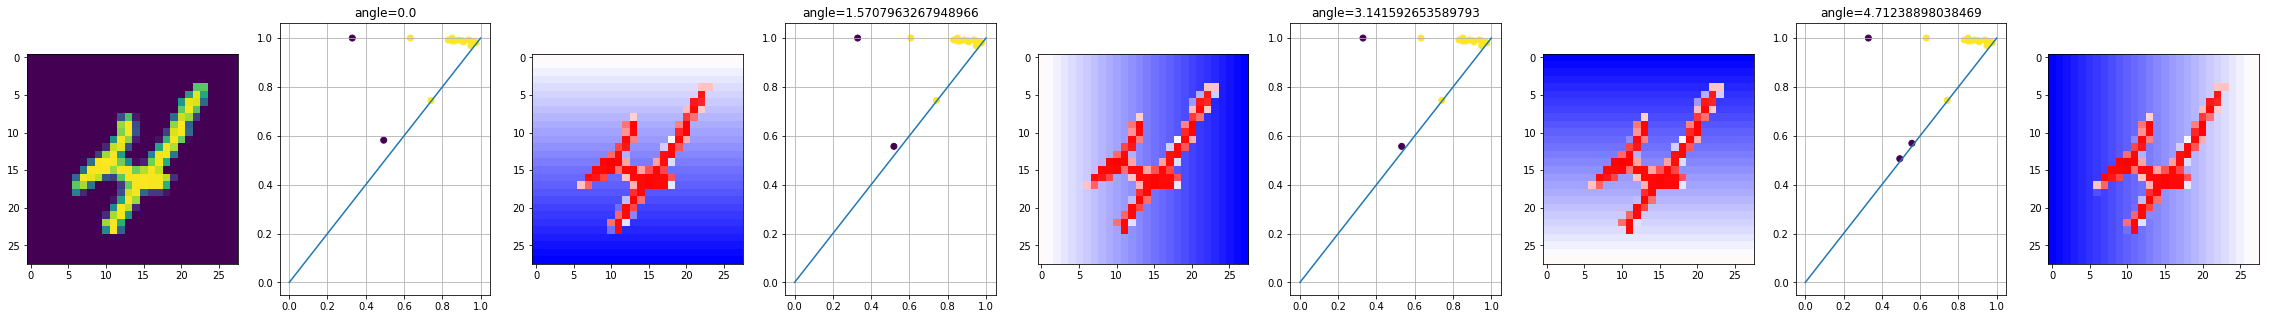

In [194]:
filter_params = np.arange(4) / 4 * 2 * math.pi

for _ in range(10):
    img0, diag, labe0, dir_img0 = mnist_filt_tr_lim[_]
    fig, axes = plt.subplots(1, 9, figsize=(40, 5))
    axes[0].imshow(img0.squeeze())
    diagonal = np.linspace(0., 1., 20)
    for i, filt_angle in enumerate(filter_params):
        # draw pd
        alpha = diag[diag[:, 3] == filt_angle]
        axes[2 * i + 1].scatter(alpha[:, 0], alpha[:, 1], c=alpha[:, 2] +1)
        axes[2 * i + 1].plot(diagonal, diagonal)
        axes[2 * i + 1].set_title(f'angle={alpha[0, 3].item()}')
        axes[2 * i + 1].grid()
        # draw img
        axes[2 * i + 2].imshow(dir_img0[i], cmap='bwr')
        
    plt.show()